# **Predicción de Eventos Extremos en Series Temporales Climáticas**
## **Método 1: Estimación Clásica por Máxima Verosimilitud (MLE)**

---

**Proyecto:** Análisis de Valores Extremos - Ecuador  
**Autor:** Jefferson Conza  
**Supervisión:** Prof. Saba Infante  
**Fecha:** Enero 2026  

---

### **Objetivos**
1. Extraer máximos por bloques de cualquier variable climática para cualquier ciudad
2. Ajustar distribución GEV mediante MLE
3. Calcular niveles de retorno para 10, 20, 50, 100 años
4. Validar modelo mediante diagnósticos estándar (Q-Q plot)
5. Generar visualizaciones listas para presentación

---

**NOTA:** Este notebook es completamente parameterizable. Solo necesita modificar el bloque de configuración (Sección 1) para analizar cualquier ciudad y variable climática.

---

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1. CONFIGURACIÓN - MODIFICAR AQUÍ**

### **INSTRUCCIONES:**
- **Edite solo este bloque** para analizar diferentes ciudades y variables
- **No modifique el código posterior** - está completamente parametrizado

### **BLOCK_RULE OPTIONS:**
- **"A" or "Y"** → Annual (yearly) maxima [~46 blocks]
- **"M" or "ME"** → Monthly maxima [~552 blocks] ⭐ RECOMMENDED
- **"D"** → Daily maxima [~16,790 blocks]
- **"H"** → Hourly (NOT RECOMMENDED)

### **Available:**
- **Variables:** temp, humidity, pressure, wind_speed, rain_1h, etc.
- **Cities:** Quito, Guayaquil, Cuenca, Manta, Esmeraldas, Loja, Ambato, Ibarra, etc.

## **1. CONFIGURACIÓN**
Modificar aquí.

### **INSTRUCCIONES:**
- **Edite solo este bloque** para analizar diferentes ciudades y variables
- **No modifique el código posterior** - está completamente parametrizado
- **Variables disponibles:** temp, humidity, pressure, wind_speed, rain_1h, etc.
- **Ciudades disponibles:** Quito, Guayaquil, Cuenca, Manta, Esmeraldas, Loja, Ambato, Ibarra, etc.

In [2]:
# ═══════════════════════════════════════════════════════════════════════════
# CONFIGURATION BLOCK — EDIT THIS SECTION ONLY
# ═══════════════════════════════════════════════════════════════════════════

# Data source
DATA_PATH = "/content/drive/MyDrive/Clima/data/data_clima_clean.parquet"

# Analysis parameters
CITY = "Quito"              # e.g., "Quito", "Guayaquil", "Esmeraldas"
VARIABLE = "temp"           # e.g., "temp", "humidity", "wind_speed", "rain_1h"

# Block choice for block maxima (EVT):
#   "YE" = annual maxima (year-end)     (~46 blocks for 46 years)
#   "ME" = monthly maxima (month-end)   (~552 blocks for 46 years)  [recommended]
#   "D"  = daily maxima                (~16k blocks)               [ok; dependence possible]
#   "H"  = hourly maxima               (NOT recommended for EVT)
BLOCK_RULE = "ME"

# Variable units mapping (extend as needed)
VARIABLE_UNITS = {
    "temp": "°C",
    "feels_like": "°C",
    "temp_min": "°C",
    "temp_max": "°C",
    "dew_point": "°C",
    "humidity": "%",
    "pressure": "hPa",
    "wind_speed": "m/s",
    "wind_gust": "m/s",
    "rain_1h": "mm",
    "rain_3h": "mm",
    "visibility": "m",
    "clouds_all": "%",
}

# Human-friendly variable names (extend as needed)
VARIABLE_NAMES = {
    "temp": "Temperature",
    "feels_like": "Feels Like Temperature",
    "temp_min": "Minimum Temperature",
    "temp_max": "Maximum Temperature",
    "dew_point": "Dew Point",
    "humidity": "Humidity",
    "pressure": "Atmospheric Pressure",
    "wind_speed": "Wind Speed",
    "wind_gust": "Wind Gust",
    "rain_1h": "Rainfall (1h)",
    "rain_3h": "Rainfall (3h)",
    "visibility": "Visibility",
    "clouds_all": "Cloud Cover",
}

# ═══════════════════════════════════════════════════════════════════════════
# DERIVED CONFIGURATION (do not edit below this line)
# ═══════════════════════════════════════════════════════════════════════════

import warnings

# Normalize and accept common aliases
_rule = str(BLOCK_RULE).upper().strip()
ALIASES = {
    "A": "YE",   # older pandas annual code
    "Y": "YE",
    "M": "ME",
}
_rule = ALIASES.get(_rule, _rule)

# Supported rules: explicit + future-proof
SUPPORTED = {
    "YE": {"pandas": "YE", "name": "Annual",  "blocks_per_year": 1},
    "ME": {"pandas": "ME", "name": "Monthly", "blocks_per_year": 12},
    "D":  {"pandas": "D",  "name": "Daily",   "blocks_per_year": 365},   # approx (ignores leap years)
    "H":  {"pandas": "H",  "name": "Hourly",  "blocks_per_year": 8760},  # not EVT-safe
}

if _rule not in SUPPORTED:
    raise ValueError(
        f"Invalid BLOCK_RULE='{BLOCK_RULE}'. Use one of: {sorted(SUPPORTED.keys())} "
        f"(aliases: A/Y→YE, M→ME)."
    )

BLOCK_RULE = _rule
PANDAS_RULE = SUPPORTED[BLOCK_RULE]["pandas"]
BLOCK_NAME = SUPPORTED[BLOCK_RULE]["name"]
BLOCKS_PER_YEAR = SUPPORTED[BLOCK_RULE]["blocks_per_year"]

UNIT = VARIABLE_UNITS.get(VARIABLE, "")
VARIABLE_NAME = VARIABLE_NAMES.get(VARIABLE, VARIABLE.replace("_", " ").title())

OUT_DIR = (
    f"/content/drive/MyDrive/Clima/results/"
    f"mle_{CITY.lower().replace(' ', '_')}_{VARIABLE}_{BLOCK_RULE.lower()}"
)

# Minimum blocks required
MIN_BLOCKS = 40 if BLOCK_RULE == "YE" else 50

# EVT-relevant warnings (minimal, actionable)
if BLOCK_RULE == "H":
    warnings.warn(
        "Hourly maxima are NOT recommended for EVT block-maxima (dependence is too strong). "
        "Use D/ME/YE instead.",
        UserWarning,
        stacklevel=2,
    )
elif BLOCK_RULE == "D":
    warnings.warn(
        "Daily maxima may still be dependent. If diagnostics look poor, prefer monthly maxima (ME).",
        UserWarning,
        stacklevel=2,
    )

print("=" * 80)
print("CONFIGURATION SUMMARY")
print("=" * 80)
print(f"Data source:       {DATA_PATH}")
print(f"City:              {CITY}")
print(f"Variable:          {VARIABLE_NAME} ({VARIABLE})")
print(f"Unit:              {UNIT}")
print(f"Block type:        {BLOCK_NAME} maxima ({BLOCK_RULE})")
print(f"Pandas rule:       '{PANDAS_RULE}'")
print(f"Blocks per year:   {BLOCKS_PER_YEAR}  (daily uses 365 ≈ ignores leap years)")
print(f"Min blocks needed: {MIN_BLOCKS}")
print(f"Output directory:  {OUT_DIR}")
print("=" * 80)

# ═══════════════════════════════════════════════════════════════════════════
# END OF CONFIGURATION BLOCK
# ═══════════════════════════════════════════════════════════════════════════

CONFIGURATION SUMMARY
Data source:       /content/drive/MyDrive/Clima/data/data_clima_clean.parquet
City:              Quito
Variable:          Temperature (temp)
Unit:              °C
Block type:        Monthly maxima (ME)
Pandas rule:       'ME'
Blocks per year:   12  (daily uses 365 ≈ ignores leap years)
Min blocks needed: 50
Output directory:  /content/drive/MyDrive/Clima/results/mle_quito_temp_me


## **2. Setup y Librerías**

In [3]:
# Imports
from __future__ import annotations

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc

from scipy import stats
from scipy.stats import genextreme
from datetime import datetime

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create output directory
os.makedirs(OUT_DIR, exist_ok=True)

print("✓ All libraries imported successfully")
print(f"✓ Output directory created: {OUT_DIR}")

✓ All libraries imported successfully
✓ Output directory created: /content/drive/MyDrive/Clima/results/mle_quito_temp_me


## **3. Validación de Configuración**

In [4]:
# Validate data file exists
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

# Load schema to validate variable exists
dataset = ds.dataset(DATA_PATH, format="parquet")
schema = dataset.schema

if VARIABLE not in schema.names:
    raise ValueError(f"Variable '{VARIABLE}' not found in dataset. Available columns: {schema.names}")

# Check variable is numeric
var_type = str(schema.field(VARIABLE).type)
if not any(t in var_type.lower() for t in ['int', 'float', 'double']):
    raise TypeError(f"Variable '{VARIABLE}' must be numeric. Found type: {var_type}")

print("✓ Data file exists")
print(f"✓ Variable '{VARIABLE}' found (type: {var_type})")
print(f"✓ Configuration validated")

✓ Data file exists
✓ Variable 'temp' found (type: float)
✓ Configuration validated


## **4. Carga de Datos**

In [5]:
# Load data for specific city using PyArrow (memory efficient)
print(f"Loading data for {CITY}...")

table = dataset.to_table(
    columns=["fecha_local", "city_name", VARIABLE],
    filter=(pc.field("city_name") == CITY)
)

df = table.to_pandas()

if len(df) == 0:
    raise ValueError(f"No data found for city '{CITY}'. Please check city name.")

df["fecha_local"] = pd.to_datetime(df["fecha_local"])
df = df.dropna(subset=[VARIABLE]).sort_values("fecha_local")

print(f"✓ Loaded {len(df):,} observations")
print(f"✓ Period: {df['fecha_local'].min().date()} to {df['fecha_local'].max().date()}")
print(f"\n{VARIABLE_NAME} statistics:")
print(df[VARIABLE].describe())

display(df.head())

Loading data for Quito...
✓ Loaded 411,112 observations
✓ Period: 1978-12-31 to 2024-10-19

Temperature statistics:
count    411112.000000
mean         13.121547
std           2.702159
min           2.970000
25%          11.070000
50%          12.530000
75%          15.050000
max          25.389999
Name: temp, dtype: float64


,fecha_local,city_name,temp
0,1978-12-31 19:00:00,Quito,13.36
1,1978-12-31 20:00:00,Quito,12.63
2,1978-12-31 21:00:00,Quito,12.05
3,1978-12-31 22:00:00,Quito,10.11
4,1978-12-31 23:00:00,Quito,10.03


## **5. Extracción de Máximos por Bloques**

Aplicamos el enfoque de **block maxima** del Teorema de Fisher-Tippett-Gnedenko:
- División en bloques no-superpuestos (mensuales o anuales)
- Extracción del máximo de cada bloque
- Preservación de valores extremos (NO eliminados como outliers)

In [6]:
# Extract block maxima
block_max = (
    df.set_index("fecha_local")[VARIABLE]
      .resample(PANDAS_RULE)
      .max()
      .dropna()
)

n_blocks = len(block_max)
period_start = block_max.index.min().date()
period_end = block_max.index.max().date()

# Validate sufficient blocks
if n_blocks < MIN_BLOCKS:
    raise ValueError(f"Insufficient blocks for reliable analysis. Found {n_blocks}, need at least {MIN_BLOCKS}.")

print("="*80)
print("BLOCK MAXIMA SUMMARY")
print("="*80)
print(f"Block type: {BLOCK_NAME} maxima")
print(f"Number of blocks: {n_blocks}")
print(f"Period: {period_start} to {period_end}")
print(f"\nStatistics of {BLOCK_NAME.lower()} maxima:")
print(block_max.describe())
print(f"\nRange: [{block_max.min():.2f}, {block_max.max():.2f}] {UNIT}")
print("="*80)

# Display first few maxima
print(f"\nFirst 10 {BLOCK_NAME.lower()} maxima:")
display(block_max.head(10))

BLOCK MAXIMA SUMMARY
Block type: Monthly maxima
Number of blocks: 551
Period: 1978-12-31 to 2024-10-31

Statistics of monthly maxima:
count    551.000000
mean      20.398876
std        1.892423
min       13.360000
25%       19.049999
50%       19.830000
75%       21.735000
max       25.389999
Name: temp, dtype: float64

Range: [13.36, 25.39] °C

First 10 monthly maxima:


,temp
fecha_local,
1978-12-31,13.360000
1979-01-31,19.420000
1979-02-28,20.650000
1979-03-31,18.940001
1979-04-30,21.030001
1979-05-31,20.340000
1979-06-30,19.590000
1979-07-31,19.340000
1979-08-31,21.620001


## **6. Visualización Exploratoria**

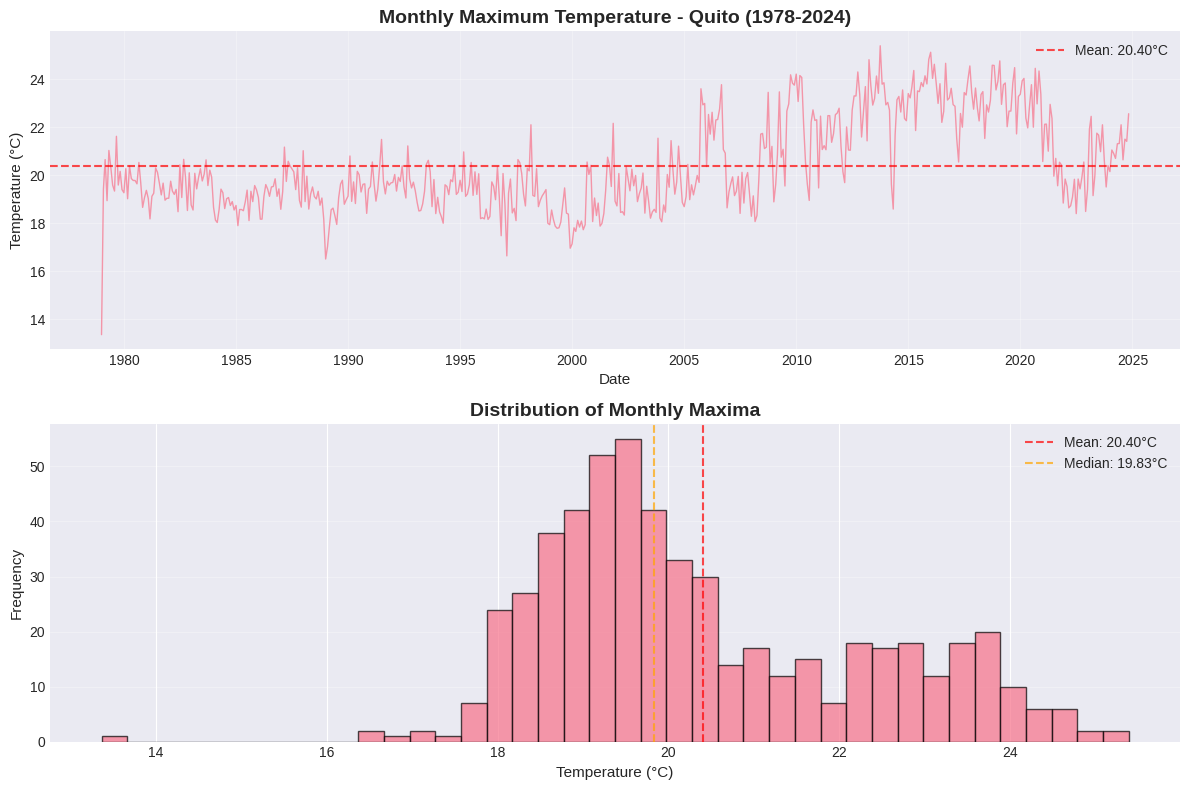

✓ Exploratory plot saved: monthly_maxima_exploratory_quito_temp.png


In [7]:
# Visualize block maxima time series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Time series plot
ax1.plot(block_max.index, block_max.values, linewidth=1, alpha=0.7)
ax1.set_title(f"{BLOCK_NAME} Maximum {VARIABLE_NAME} - {CITY} ({period_start.year}-{period_end.year})",
             fontsize=14, fontweight='bold')
ax1.set_xlabel("Date", fontsize=11)
ax1.set_ylabel(f"{VARIABLE_NAME} ({UNIT})", fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.axhline(block_max.mean(), color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {block_max.mean():.2f}{UNIT}', alpha=0.7)
ax1.legend()

# Distribution plot
ax2.hist(block_max.values, bins=40, edgecolor='black', alpha=0.7)
ax2.set_title(f"Distribution of {BLOCK_NAME} Maxima", fontsize=14, fontweight='bold')
ax2.set_xlabel(f"{VARIABLE_NAME} ({UNIT})", fontsize=11)
ax2.set_ylabel("Frequency", fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.axvline(block_max.mean(), color='red', linestyle='--', linewidth=1.5,
            label=f'Mean: {block_max.mean():.2f}{UNIT}', alpha=0.7)
ax2.axvline(block_max.median(), color='orange', linestyle='--', linewidth=1.5,
            label=f'Median: {block_max.median():.2f}{UNIT}', alpha=0.7)
ax2.legend()

plt.tight_layout()
exploratory_path = f"{OUT_DIR}/{BLOCK_NAME.lower()}_maxima_exploratory_{CITY.lower().replace(' ', '_')}_{VARIABLE}.png"
plt.savefig(exploratory_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Exploratory plot saved: {os.path.basename(exploratory_path)}")

## **7. Ajuste de Distribución GEV por MLE**

### **Teoría**

**Distribución GEV:**
$$G(x; \mu, \sigma, \xi) = \exp\left\{-\left[1 + \xi\left(\frac{x-\mu}{\sigma}\right)\right]^{-1/\xi}\right\}$$

Donde:
- $\mu$ = parámetro de ubicación (location)
- $\sigma$ = parámetro de escala (scale)
- $\xi$ = parámetro de forma (shape)

**Interpretación de $\xi$:**
- $\xi > 0$: Fréchet (colas pesadas)
- $\xi = 0$: Gumbel (colas exponenciales)
- $\xi < 0$: Weibull (colas acotadas, límite superior finito)

In [8]:
# Fit GEV distribution using Maximum Likelihood Estimation
# Note: scipy uses c = -xi parameterization

print("Fitting GEV distribution via MLE...")
c, mu_hat, sigma_hat = genextreme.fit(block_max.values)
xi_hat = -c

print("\n" + "="*80)
print("GEV PARAMETERS (Maximum Likelihood Estimation)")
print("="*80)
print(f"μ (location) = {mu_hat:.4f} {UNIT}")
print(f"σ (scale)    = {sigma_hat:.4f} {UNIT}")
print(f"ξ (shape)    = {xi_hat:.4f}")
print("="*80)

# Interpret shape parameter
print("\nINTERPRETATION:")
if xi_hat < -0.05:
    tail_type = "Weibull"
    interpretation = "Bounded tail - finite upper limit"
    endpoint = mu_hat - sigma_hat/xi_hat
    print(f"→ Type: {tail_type} (ξ < 0)")
    print(f"→ {interpretation}")
    print(f"→ Implied upper endpoint: {endpoint:.2f} {UNIT}")
elif xi_hat > 0.05:
    tail_type = "Fréchet"
    interpretation = "Heavy tail - higher probability of extreme values"
    endpoint = None
    print(f"→ Type: {tail_type} (ξ > 0)")
    print(f"→ {interpretation}")
    print(f"→ No finite upper bound")
else:
    tail_type = "Gumbel"
    interpretation = "Exponential tail - moderate extremes"
    endpoint = None
    print(f"→ Type: {tail_type} (ξ ≈ 0)")
    print(f"→ {interpretation}")
    print(f"→ Unbounded tail with exponential decay")

print("\n" + "="*80)

Fitting GEV distribution via MLE...

GEV PARAMETERS (Maximum Likelihood Estimation)
μ (location) = 19.6295 °C
σ (scale)    = 1.6734 °C
ξ (shape)    = -0.1373

INTERPRETATION:
→ Type: Weibull (ξ < 0)
→ Bounded tail - finite upper limit
→ Implied upper endpoint: 31.82 °C



## **8. Cálculo de Niveles de Retorno**

**Return Level:** Valor que será excedido con probabilidad $1/T$ en cada período

In [9]:
# Calculate return levels for key return periods
T_years = np.array([10, 20, 50, 100], dtype=float)
T_blocks = BLOCKS_PER_YEAR * T_years  # Convert years to blocks

# Return level: value exceeded with probability 1/T
return_levels = genextreme.ppf(1 - 1/T_blocks, c, loc=mu_hat, scale=sigma_hat)

print("\n" + "="*80)
print(f"RETURN LEVELS ({VARIABLE_NAME} exceeded once every N years)")
print("="*80)
print(f"{'Return Period':<20} {VARIABLE_NAME + ' (' + UNIT + ')':<20}")
print("-"*80)
for T, rl in zip(T_years, return_levels):
    print(f"{int(T):>3d} years{'':<13} {rl:>8.2f} {UNIT}")
print("="*80)

# Additional return periods for smooth curve
T_curve = np.logspace(0, 2.5, 300)  # 1 to ~316 years
RL_curve = genextreme.ppf(1 - 1/(BLOCKS_PER_YEAR*T_curve), c, loc=mu_hat, scale=sigma_hat)

print(f"\n✓ Return levels calculated for {len(T_years)} key periods")


RETURN LEVELS (Temperature exceeded once every N years)
Return Period        Temperature (°C)    
--------------------------------------------------------------------------------
 10 years                 25.50 °C
 20 years                 26.07 °C
 50 years                 26.75 °C
100 years                 27.21 °C

✓ Return levels calculated for 4 key periods


## **9. Diagnósticos del Modelo - Q-Q Plot**

El **Q-Q plot** compara los cuantiles empíricos con los cuantiles teóricos de la distribución GEV ajustada.

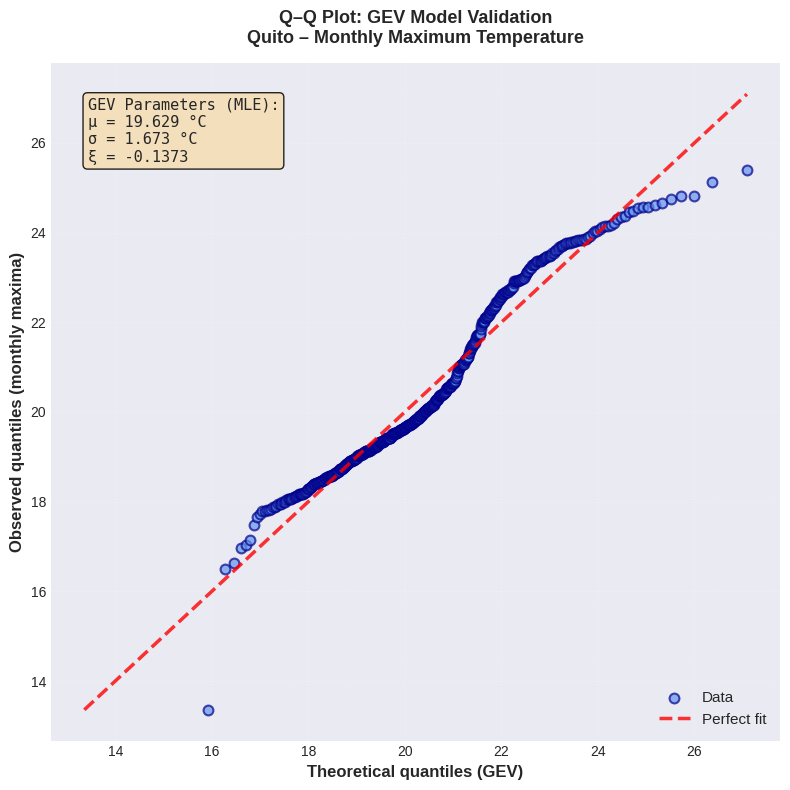

✓ Q-Q plot saved: qq_plot_quito_temp.png


In [10]:
# Q-Q Plot for model validation
emp_q = np.sort(block_max.values)
p = (np.arange(1, len(emp_q)+1) - 0.44) / (len(emp_q) + 0.12)  # Filliben plotting position
theo_q = genextreme.ppf(p, c, loc=mu_hat, scale=sigma_hat)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot
ax.scatter(theo_q, emp_q, s=50, alpha=0.7, edgecolors='darkblue',
           facecolors='cornflowerblue', linewidths=1.5, label='Data')

# Perfect fit line
mn = min(theo_q.min(), emp_q.min())
mx = max(theo_q.max(), emp_q.max())
ax.plot([mn, mx], [mn, mx], "r--", lw=2.5, label="Perfect fit", alpha=0.8)

# Styling
ax.set_xlabel("Theoretical quantiles (GEV)", fontsize=12, fontweight='bold')
ax.set_ylabel(f"Observed quantiles ({BLOCK_NAME.lower()} maxima)", fontsize=12, fontweight='bold')
ax.set_title(f"Q–Q Plot: GEV Model Validation\n{CITY} – {BLOCK_NAME} Maximum {VARIABLE_NAME}",
            fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.legend(fontsize=11, loc='lower right')

# Add parameter box
textstr = f'GEV Parameters (MLE):\nμ = {mu_hat:.3f} {UNIT}\nσ = {sigma_hat:.3f} {UNIT}\nξ = {xi_hat:.4f}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
qq_path = f"{OUT_DIR}/qq_plot_{CITY.lower().replace(' ', '_')}_{VARIABLE}.png"
plt.savefig(qq_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Q-Q plot saved: {os.path.basename(qq_path)}")

## **10. Return Level Plot**

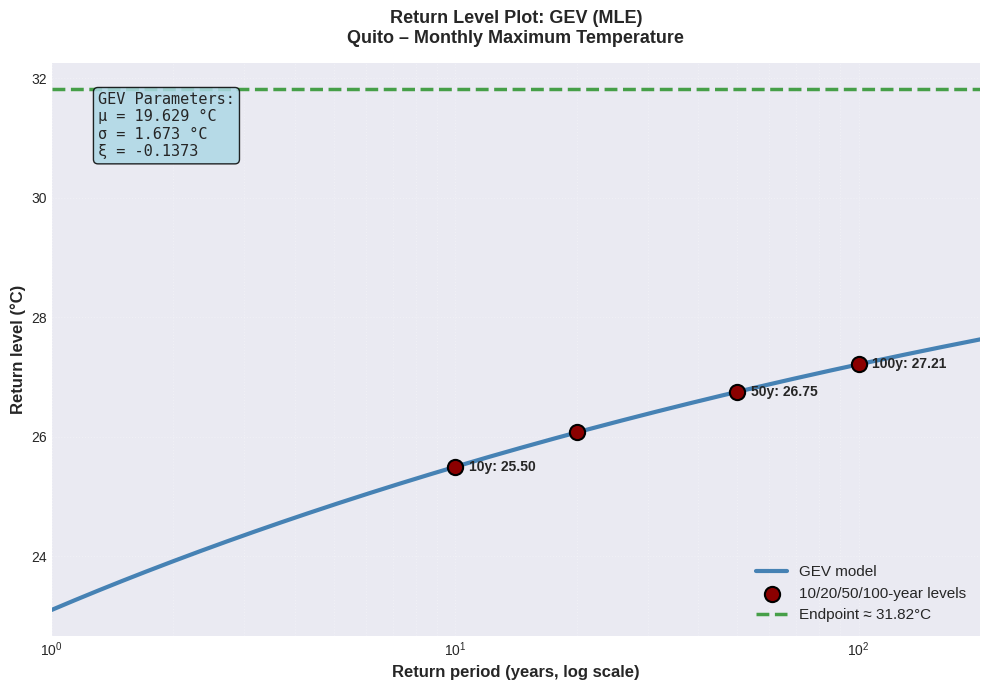

✓ Return level plot saved: return_level_plot_quito_temp.png


In [11]:
# Return Level Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Theoretical return level curve
ax.plot(T_curve, RL_curve, lw=3, label="GEV model", color='steelblue')

# Key return levels
ax.scatter(T_years, return_levels, s=120, zorder=5,
          color='darkred', edgecolors='black', linewidths=1.5,
          label="10/20/50/100-year levels")

# Annotate key points
for T, rl in zip(T_years, return_levels):
    if T in [10, 50, 100]:
        ax.text(T*1.08, rl, f"{int(T)}y: {rl:.2f}",
               fontsize=10, va="center", fontweight='bold')

# Add endpoint line if Weibull
if xi_hat < 0 and endpoint is not None:
    ax.axhline(endpoint, ls="--", lw=2.5, alpha=0.7, color='green',
              label=f"Endpoint ≈ {endpoint:.2f}{UNIT}")

# Styling
ax.set_xscale("log")
ax.set_xlabel("Return period (years, log scale)", fontsize=12, fontweight='bold')
ax.set_ylabel(f"Return level ({UNIT})", fontsize=12, fontweight='bold')
ax.set_title(f"Return Level Plot: GEV (MLE)\n{CITY} – {BLOCK_NAME} Maximum {VARIABLE_NAME}",
            fontsize=13, fontweight='bold', pad=15)
ax.grid(True, which="both", alpha=0.3, linestyle=':', linewidth=0.8)
ax.legend(fontsize=11, loc='lower right')
ax.set_xlim([1, 200])

# Add parameter box
textstr = f'GEV Parameters:\nμ = {mu_hat:.3f} {UNIT}\nσ = {sigma_hat:.3f} {UNIT}\nξ = {xi_hat:.4f}'
props = dict(boxstyle='round', facecolor='lightblue', alpha=0.85)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
        verticalalignment='top', bbox=props, family='monospace')

plt.tight_layout()
rl_path = f"{OUT_DIR}/return_level_plot_{CITY.lower().replace(' ', '_')}_{VARIABLE}.png"
plt.savefig(rl_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Return level plot saved: {os.path.basename(rl_path)}")

## **11. Histogram con Densidad Ajustada**

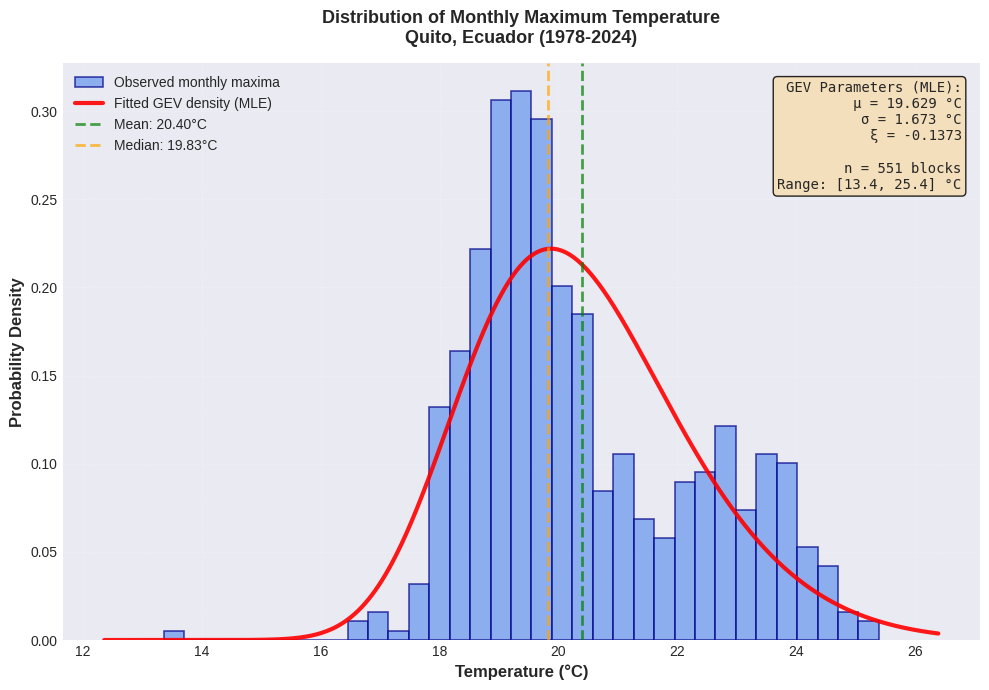

✓ Histogram saved: histogram_fitted_gev_quito_temp.png


In [12]:
# Histogram with fitted GEV density
x_range = np.linspace(float(block_max.min())-1, float(block_max.max())+1, 500)
pdf_fitted = genextreme.pdf(x_range, c, loc=mu_hat, scale=sigma_hat)

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Histogram
counts, bins, patches = ax.hist(block_max.values, bins=35, density=True,
                                alpha=0.7, edgecolor="darkblue", linewidth=1.2,
                                color='cornflowerblue',
                                label=f"Observed {BLOCK_NAME.lower()} maxima")

# Fitted density
ax.plot(x_range, pdf_fitted, lw=3, color='red',
       label="Fitted GEV density (MLE)", alpha=0.9)

# Add mean and median lines
ax.axvline(block_max.mean(), color='green', linestyle='--', lw=2,
          alpha=0.7, label=f'Mean: {block_max.mean():.2f}{UNIT}')
ax.axvline(block_max.median(), color='orange', linestyle='--', lw=2,
          alpha=0.7, label=f'Median: {block_max.median():.2f}{UNIT}')

# Styling
ax.set_xlabel(f"{VARIABLE_NAME} ({UNIT})", fontsize=12, fontweight='bold')
ax.set_ylabel("Probability Density", fontsize=12, fontweight='bold')
ax.set_title(f"Distribution of {BLOCK_NAME} Maximum {VARIABLE_NAME}\n{CITY}, Ecuador ({period_start.year}-{period_end.year})",
            fontsize=13, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
ax.legend(fontsize=10, loc='upper left')

# Add parameter box
textstr = (f'GEV Parameters (MLE):\n'
          f'μ = {mu_hat:.3f} {UNIT}\n'
          f'σ = {sigma_hat:.3f} {UNIT}\n'
          f'ξ = {xi_hat:.4f}\n'
          f'\n'
          f'n = {n_blocks} blocks\n'
          f'Range: [{block_max.min():.1f}, {block_max.max():.1f}] {UNIT}')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.85)
ax.text(0.98, 0.97, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=props, family='monospace')

plt.tight_layout()
hist_path = f"{OUT_DIR}/histogram_fitted_gev_{CITY.lower().replace(' ', '_')}_{VARIABLE}.png"
plt.savefig(hist_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Histogram saved: {os.path.basename(hist_path)}")

## **12. Resumen de Resultados**

In [13]:
# Generate comprehensive summary
summary_lines = []
summary_lines.append("="*80)
summary_lines.append("PRELIMINARY EVT RESULTS (Method 1: GEV via MLE)")
summary_lines.append("Extreme Value Analysis - Ecuador Climate Data")
summary_lines.append("="*80)
summary_lines.append("")
summary_lines.append("DATASET INFORMATION")
summary_lines.append("-"*80)
summary_lines.append(f"Source: {DATA_PATH}")
summary_lines.append(f"City: {CITY}")
summary_lines.append(f"Variable: {VARIABLE_NAME} ({VARIABLE})")
summary_lines.append(f"Period: {period_start} to {period_end}")
summary_lines.append(f"Total observations: {len(df):,}")
summary_lines.append("")
summary_lines.append("BLOCK MAXIMA")
summary_lines.append("-"*80)
summary_lines.append(f"Block type: {BLOCK_NAME} maxima")
summary_lines.append(f"Number of blocks: {n_blocks}")
summary_lines.append(f"Range: [{block_max.min():.2f}, {block_max.max():.2f}] {UNIT}")
summary_lines.append(f"Mean: {block_max.mean():.2f} {UNIT}")
summary_lines.append(f"Std: {block_max.std():.2f} {UNIT}")
summary_lines.append("")
summary_lines.append("GEV PARAMETERS (Maximum Likelihood Estimation)")
summary_lines.append("-"*80)
summary_lines.append(f"μ (location) = {mu_hat:.4f} {UNIT}")
summary_lines.append(f"σ (scale)    = {sigma_hat:.4f} {UNIT}")
summary_lines.append(f"ξ (shape)    = {xi_hat:.4f}")
summary_lines.append("")
summary_lines.append("INTERPRETATION")
summary_lines.append("-"*80)
if xi_hat < -0.05:
    summary_lines.append(f"Type: Weibull (ξ < 0)")
    summary_lines.append(f"Tail behavior: Bounded tail - finite upper limit")
    summary_lines.append(f"Upper endpoint: ≈ {endpoint:.2f} {UNIT}")
elif xi_hat > 0.05:
    summary_lines.append(f"Type: Fréchet (ξ > 0)")
    summary_lines.append(f"Tail behavior: Heavy tail - higher probability of extremes")
    summary_lines.append(f"Upper bound: Unbounded")
else:
    summary_lines.append(f"Type: Gumbel (ξ ≈ 0)")
    summary_lines.append(f"Tail behavior: Exponential tail - moderate extremes")
    summary_lines.append(f"Upper bound: Unbounded with exponential decay")
summary_lines.append("")
summary_lines.append(f"RETURN LEVELS ({VARIABLE_NAME} exceeded once every N years)")
summary_lines.append("-"*80)
for T, rl in zip(T_years, return_levels):
    summary_lines.append(f"{int(T):>3d}-year return level: {rl:.2f} {UNIT}")
summary_lines.append("")
summary_lines.append("QUICK SUMMARY FOR SLIDES")
summary_lines.append("-"*80)
summary_lines.append(f"GEV (MLE): mu={mu_hat:.3f}, sigma={sigma_hat:.3f}, xi={xi_hat:.3f}")
rl_str = ", ".join([f"{int(T)}y={rl:.2f}" for T, rl in zip(T_years, return_levels)])
summary_lines.append(f"Return levels: {rl_str} ({UNIT})")
if xi_hat < 0 and endpoint is not None:
    summary_lines.append(f"Endpoint: ≈{endpoint:.2f}{UNIT}")
summary_lines.append("")
summary_lines.append("OUTPUT FILES")
summary_lines.append("-"*80)
summary_lines.append(f"1. Q-Q plot: {os.path.basename(qq_path)}")
summary_lines.append(f"2. Return level plot: {os.path.basename(rl_path)}")
summary_lines.append(f"3. Histogram: {os.path.basename(hist_path)}")
summary_lines.append(f"4. Exploratory: {os.path.basename(exploratory_path)}")
summary_lines.append("")
summary_lines.append("="*80)
summary_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
summary_lines.append(f"City: {CITY}")
summary_lines.append(f"Variable: {VARIABLE_NAME}")
summary_lines.append(f"Author: Jefferson Conza")
summary_lines.append(f"Supervisor: Prof. Saba Infante")
summary_lines.append("="*80)

summary_text = "\n".join(summary_lines)

# Save summary
summary_path = f"{OUT_DIR}/MLE_summary_{CITY.lower().replace(' ', '_')}_{VARIABLE}.txt"
with open(summary_path, "w", encoding="utf-8") as f:
    f.write(summary_text)

print("\n" + summary_text)
print(f"\n✓ Summary saved: {os.path.basename(summary_path)}")


PRELIMINARY EVT RESULTS (Method 1: GEV via MLE)
Extreme Value Analysis - Ecuador Climate Data

DATASET INFORMATION
--------------------------------------------------------------------------------
Source: /content/drive/MyDrive/Clima/data/data_clima_clean.parquet
City: Quito
Variable: Temperature (temp)
Period: 1978-12-31 to 2024-10-31
Total observations: 411,112

BLOCK MAXIMA
--------------------------------------------------------------------------------
Block type: Monthly maxima
Number of blocks: 551
Range: [13.36, 25.39] °C
Mean: 20.40 °C
Std: 1.89 °C

GEV PARAMETERS (Maximum Likelihood Estimation)
--------------------------------------------------------------------------------
μ (location) = 19.6295 °C
σ (scale)    = 1.6734 °C
ξ (shape)    = -0.1373

INTERPRETATION
--------------------------------------------------------------------------------
Type: Weibull (ξ < 0)
Tail behavior: Bounded tail - finite upper limit
Upper endpoint: ≈ 31.82 °C

RETURN LEVELS (Temperature exceeded on

## **13. Verificación Final**

In [14]:
# Final verification and file list
print("\n" + "="*80)
print("FINAL VERIFICATION")
print("="*80)

# Check all output files exist
expected_files = [
    os.path.basename(qq_path),
    os.path.basename(rl_path),
    os.path.basename(hist_path),
    os.path.basename(exploratory_path),
    os.path.basename(summary_path)
]

print("\nChecking output files:")
all_exist = True
for filename in expected_files:
    filepath = os.path.join(OUT_DIR, filename)
    exists = os.path.exists(filepath)
    status = "✓" if exists else "✗"
    print(f"  {status} {filename}")
    all_exist = all_exist and exists

if all_exist:
    print("\n" + "="*80)
    print("✅ ALL FILES GENERATED SUCCESSFULLY")
    print("="*80)
    print(f"\n📂 Output directory: {OUT_DIR}")
    print("\n🎯 ANALYSIS COMPLETE")
    print("="*80)
else:
    print("\n⚠️  WARNING: Some files are missing!")

# Display parameter summary one more time
print("\n" + "="*80)
print("KEY RESULTS TO REMEMBER")
print("="*80)
print(f"City: {CITY}")
print(f"Variable: {VARIABLE_NAME} ({VARIABLE})")
print(f"Dataset: {n_blocks} {BLOCK_NAME.lower()} maxima ({period_start} to {period_end})")
print(f"GEV parameters: μ={mu_hat:.3f}, σ={sigma_hat:.3f}, ξ={xi_hat:.3f}")
print(f"Distribution type: {tail_type}")
print(f"100-year return level: {return_levels[3]:.2f} {UNIT}")
if endpoint is not None:
    print(f"Physical upper limit: ≈{endpoint:.2f} {UNIT}")
print("="*80)


FINAL VERIFICATION

Checking output files:
  ✓ qq_plot_quito_temp.png
  ✓ return_level_plot_quito_temp.png
  ✓ histogram_fitted_gev_quito_temp.png
  ✓ monthly_maxima_exploratory_quito_temp.png
  ✓ MLE_summary_quito_temp.txt

✅ ALL FILES GENERATED SUCCESSFULLY

📂 Output directory: /content/drive/MyDrive/Clima/results/mle_quito_temp_me

🎯 ANALYSIS COMPLETE

KEY RESULTS TO REMEMBER
City: Quito
Variable: Temperature (temp)
Dataset: 551 monthly maxima (1978-12-31 to 2024-10-31)
GEV parameters: μ=19.629, σ=1.673, ξ=-0.137
Distribution type: Weibull
100-year return level: 27.21 °C
Physical upper limit: ≈31.82 °C
